In [1]:
import numpy as np
import sys
from io import BytesIO
from flask import Flask, render_template, send_file, make_response, request

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from mpl_toolkits.axes_grid1 import make_axes_locatable  #--- For colortables

from interp3d import interp_3d
from scipy.interpolate import RegularGridInterpolator

/opt/miniconda3/envs/Astro/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
sys.path.insert(0, '/Users/miguel/Develop/python_utils/')
sys.path.insert(0, '/Users/miguel/Develop/python_utils/SDSS/')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from SDSS_viewer.compute import *
from idl import *

***
***
***

### Read density field map

In [9]:
PATH = '/Users/miguel/Projects/SDSS_density_explorer/Data/'
FILE_DENS = 'DR13_D_all_random_boundary.ENS-256.SIG-0.5.weighted-masked-delta1.fvol'
FILE_MASK = 'DR13_D_all.3D_MASK.bvol'

#--- Read volume as global variable
print('>>> Reading density field...')
vol_den = read_fvolume(PATH + FILE_DENS)
vol_den = np.asfarray( vol_den, dtype='float' )

print('>>> Reading mask...')
mask = read_bvolume(PATH + FILE_MASK)


>>> Reading density field...
>>> Reading volume of size: 1024 512 512
>>> Reading mask...
>>> Reading volume of size: 1024 512 512


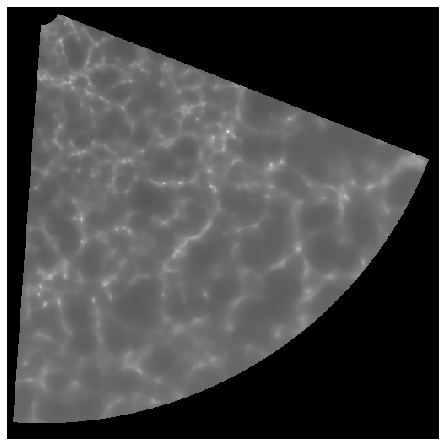

In [10]:
tvscale( vol_den[511,:,:]**0.1 )

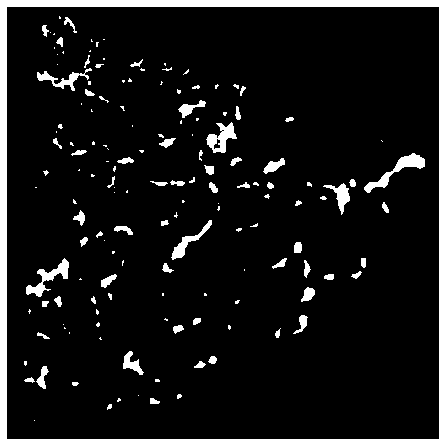

In [11]:
tvscale( (vol_den[511,:,:] > 3))

### Define map properties

In [13]:
mapp = {'x0':0.5, 'y0':0.0, 'z0':0.04, 'max_l':1024, 'H_o':73.0, 'c_l':299792.458}

### Read MANGA sample

In [14]:
FILE_CSV = '/Users/miguel/Science/Hector/Data/BSF_v5.1.csv'
manga = np.genfromtxt(FILE_CSV, delimiter=',', skip_header=1, dtype=None, encoding='utf-8')

### This is the target galaxy

In [34]:
gal_i = 2

target = {'ra':manga[gal_i][1], 'dec':manga[gal_i][2], 'z':manga[gal_i][3]}
target

{'ra': 150.071302979, 'dec': 4.8887850018, 'z': 0.0132365}

***

In [35]:
x = np.linspace(0,1024,1024)
y = np.linspace(0,511,512)
z = np.linspace(0,511,512)

X,Y,Z = np.meshgrid(x,y,z,indexing='ij')
interp = interp_3d.Interp3D(vol_den, x,y,z)

{'ra': 150.071302979, 'dec': 4.8887850018, 'z': 0.0132365}


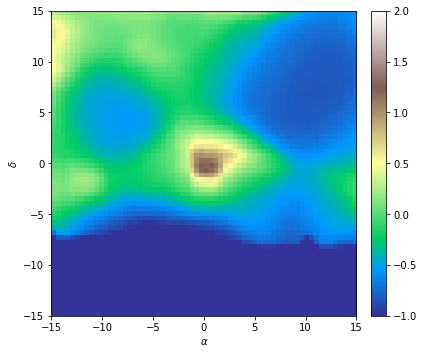

In [68]:
#--------------------------------------------
#  Redshift (sky) projection (RA,DEC)
#--------------------------------------------

print(target)

ra_delta  = 30
dec_delta = 30

ima = get_reds_slice_simple(vol_den, interp, target, 
                            ra_delta=ra_delta, dec_delta=dec_delta, n_ra=64, n_dec=64,mapp=mapp)

x1 = -ra_delta/2
x2 =  ra_delta/2
y1 = -dec_delta/2
y2 =  dec_delta/2

fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = [6, 6]

ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\delta$')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)

im = ax.imshow(np.log10(ima+0.001), origin='lower', cmap='terrain',extent=[x1,x2,y1,y2],vmin=-1, vmax=2)

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

{'ra': 150.071302979, 'dec': 4.8887850018, 'z': 0.0132365}
0.0256063


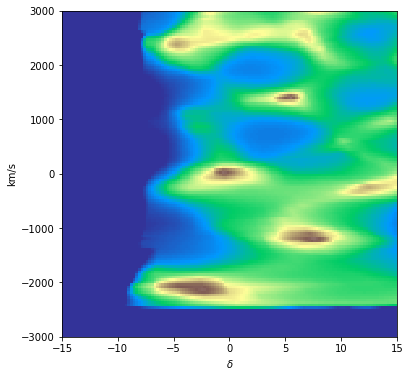

In [69]:
#--------------------------------------------
#  Right Ascencion slice (DEC,z)
#--------------------------------------------

print(target)

dec_delta=30

c_l = 300000.0
z_delta = 0.02

print(manga[0][3])
ima = get_ra_slice(vol_den=vol_den, interp=interp, target=target, 
                   dec_delta=dec_delta, reds_delta=z_delta, n_dec=128, n_reds=128, mapp=mapp)

x1 = -dec_delta/2
x2 =  dec_delta/2
y1 = -(z_delta/2)*c_l
y2 =  (z_delta/2)*c_l
fig, ax = plt.subplots(1)
plt.rcParams['figure.figsize'] = [6, 8]
ax.set_xlabel(r'$\delta$')
ax.set_ylabel('km/s')
plt.imshow(np.log10(ima+0.001),interpolation="none", origin='lower',cmap='terrain',extent=[x1,x2,y1,y2],aspect='auto',vmin=-1, vmax=2)
plt.show()

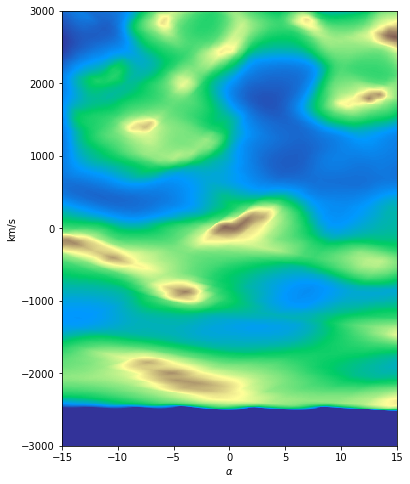

In [61]:
#--------------------------------------------
#  Declination slice (RA,z)
#--------------------------------------------


ra_delta = 30

c_l = 300000.0
z_delta = 0.02

ima = get_dec_slice(vol_den, interp, target=target, 
                            ra_delta=ra_delta, reds_delta=z_delta, n_ra=512, n_reds=512, mapp=mapp)
    
x1 = -ra_delta/2
x2 =  ra_delta/2
y1 = -(z_delta/2)*c_l
y2 =  (z_delta/2)*c_l

fig, ax = plt.subplots(1)
plt.rcParams['figure.figsize'] = [4,4]
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('km/s')
plt.imshow(np.log10(ima+0.001),interpolation="none", origin='lower',cmap='terrain',extent=[x1,x2,y1,y2],aspect='auto',vmin=-1, vmax=2)
plt.show()

radius =  2.5
0.6419594453386903 11.919838054743103


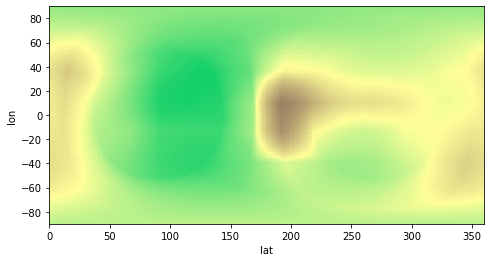

radius =  5.0
0.1779388360846877 5.949917106856727


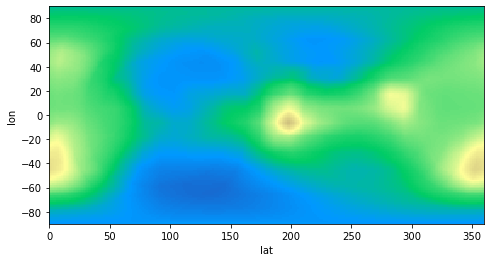

radius =  7.5
0.016881542037699728 2.9256498122679795


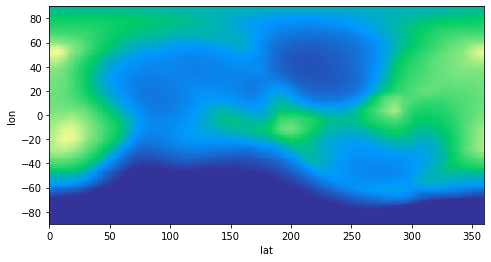

radius =  10.0
0.0 16.62982167572158


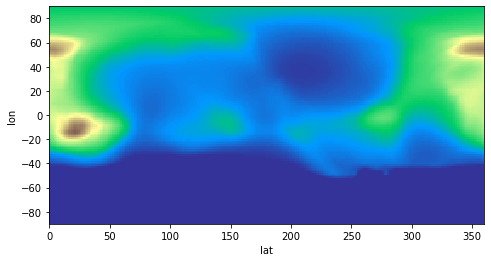

In [66]:
#--------------------------------------------
#  Sphere around galaxy
#--------------------------------------------

for i in range(1,5):

    radius = i*2.5
    print('radius = ', radius)
    
    ima = get_sphere_simple(vol_den, interp, target=target, 
                            n_lon=256, n_lat=128, radius=radius, mapp=mapp)

    print(np.min(ima), np.max(ima))
    
    x1 = 0
    x2 = 360
    y1 = -90
    y2 = 90
    fig, ax = plt.subplots(1)
    plt.rcParams['figure.figsize'] = [8,4] 
    ax.set_xlabel('lat')
    ax.set_ylabel('lon')
    plt.imshow(np.log10(ima+0.001),interpolation="none", origin='lower',cmap='terrain',extent=[x1,x2,y1,y2],vmin=-1, vmax=2)
    
    plt.show()